In [ ]:
library(tidyverse)
library(readxl)
library(writexl)
library(pheatmap)
library(corrplot)
library(ggpubr)
library(Matrix)
library(paletteer)

library(org.Hs.eg.db)
library(GSVA)
library(GSEABase)
library(clusterProfiler)

library(Seurat)

library(patchwork)
library(ggrepel)
library(repr)

In [2]:
mainColor=paletteer_d("basetheme::clean")[c(1:8)]
fineColor=paletteer_d("ggsci::default_ucscgb")

# load scdata

In [3]:
scdata=readRDS("/data2/xiangwei/projects/zhaolian/10polyIntegrate/results/sctAnnotationSeuObj")

In [4]:
mainCellType=names(table(scdata$main))

In [ ]:
names(mainCellType)=mainColor
mainCellType

In [6]:
metadata=scdata@meta.data

In [7]:
#metadata$harmony_cluster=as.character(metadata$harmony_cluster)
#metadata$sampleID=as.character(metadata$sampleID)
head(metadata)

,nCount_RNA,nFeature_RNA,sampleID,percent.mt,Phase,sampleType,sampleTypeFine,nCount_SCT,nFeature_SCT,unintegrated_clusters,seurat_clusters,cca_cluster,rpca_cluster,harmony_cluster,main,fine
,<dbl>,<dbl>,<fct>,<dbl>,<chr>,<chr>,<fct>,<dbl>,<int>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>,<fct>
WT_1.bcHTXJ,5633,2155,WT1,3.586011,G1,normal,WT1,2575,1386,8,10,16,10,10,Epithelial,Epi-Krt20
WT_1.bcHGRE,10487,3855,WT1,5.912082,G2M,normal,WT1,2180,1408,8,11,0,9,11,Epithelial,Epi-Srgn
WT_1.bcHIFA,9429,3137,WT1,6.352742,G2M,normal,WT1,2197,1152,8,10,16,10,10,Epithelial,Epi-Krt20
WT_1.bcHFJN,7902,2746,WT1,7.884080,G1,normal,WT1,2205,1178,8,10,16,10,10,Epithelial,Epi-Krt20
WT_1.bcGOTP,7605,3330,WT1,4.865220,S,normal,WT1,2136,1383,20,0,11,22,0,Neutrophil,Neutrophil
WT_1.bcFBTL,8837,2901,WT1,6.551997,G1,normal,WT1,2213,1189,8,10,3,10,10,Epithelial,Epi-Krt20


# set color

In [8]:
col=colorRampPalette(c("blue", "red"))(50)

# load Np Value

In [9]:
npvalue=read_xlsx("/data2/xiangwei/projects/zhaolian_old/BfinalSample/Np_new2.xlsx")%>% select(sampleID,Np,`1/Np`)

In [10]:
wt=tribble(~sampleID,~Np,~`1/Np`,
         "WT1",100,0.01,
         "WT2",100,0.01)

In [11]:
npvalue=rbind(npvalue,wt)
npvalue

sampleID,Np,1/Np
<chr>,<dbl>,<dbl>
148_T1,1.604244,0.62334657
148_T3,2.670790,0.37442101
142_T5-4,2.802020,0.35688537
132_T1,4.075022,0.24539743
142_T2,5.653750,0.17687375
18_T3,6.088663,0.16423968
18_T4,9.575361,0.10443470
17_T4,11.891945,0.08409053
151_T4,32.589013,0.03068519


# cellType data

In [13]:
table(metadata$harmony_cluster)
table(metadata$fine)
dim(metadata)
table(metadata$sampleID)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7155 4568 4114 3421 3390 2350 2225 2075 1595 1578 1306 1288 1278 1132 1106 1037 
  16   17   18   19   20   21   22   23   24   25 
 896  781  764  727  722  578  568  395  313  258 


      Epi-Mt3     Epi-Mgst3     Epi-Peak1     Epi-Mdga2     Epi-Ptprd 
         4568          4114          2225          2075          1578 
    Epi-Krt20      Epi-Srgn    Epi-Goblet    Epi-Arglu1 Epi-Stem-like 
         1306          1288          1278           727           395 
   Fibroblast   Endothelial          Mast  T-Regulatory   T-Cytotoxic 
          258           781           722          3390           896 
 T-Progenitor             B      B-Plasma    Neutrophil   Macro-Trem2 
          578          1106           764          7155          3421 
  Macro-Chil3  Macro-Ifitm1   Macro-Acod1   Macro-Cxcl3    Macro-St18 
         2350          1595          1132          1037           568 
   Macro-Ccr7 
          313 

[1] 45620    16


  148_T1   148_T3 142_T5-4   132_T1   142_T2    18_T3    18_T4    17_T4 
    5110     3812     4879     4387     4389     5304     2109     7870 
  151_T4      WT1      WT2 
    5141     1387     1232 

In [14]:
epidata=metadata%>%filter(harmony_cluster %in% c(1,2,6,7,9,10,11,12,19,23))
dim(epidata)
epidata$fine=as.character(epidata$fine)

[1] 19554    16

In [15]:
immunedata=metadata%>%filter(harmony_cluster %in% c(0,3,4,5,8,13,14,15,16,18,21,22,24))
dim(immunedata)
immunedata$fine=as.character(immunedata$fine)

[1] 24305    16

In [16]:
macrodata=metadata%>%filter(harmony_cluster %in% c(3,5,8,13,15,22,24))
dim(macrodata)
macrodata$fine=as.character(macrodata$fine)

[1] 10416    16

# corr

In [17]:
data=metadata

In [18]:
pctMatrix=table(data$fine,data$sampleID) %>% as.data.frame() %>%
             as_tibble()  %>% set_names(c("cellType","sampleID","num"))%>% 
             pivot_wider(names_from = sampleID, values_from = num) %>% as.data.frame() %>% arrange(cellType)
#%>%select(-WT1,-WT2)

In [19]:
rownames(pctMatrix)=pctMatrix$cellType
pctMatrix=pctMatrix[,-1]

In [20]:
scaleF=function(x){
    cellnum=x/sum(x)
}

In [21]:
scaledpctMatrix=map_dfc(pctMatrix,scaleF)

In [22]:
scaledpctMatrix=as.data.frame(scaledpctMatrix)
rownames(scaledpctMatrix)=rownames(pctMatrix)

In [ ]:
head(scaledpctMatrix)    
colnames(scaledpctMatrix)

In [24]:
matrix=t(scaledpctMatrix)

In [25]:
sampleid=rownames(matrix)

In [26]:
matrixCombind=as_tibble(matrix)%>%mutate(sampleID=sampleid)%>%
#relocate(sampleID,.before = `Eip-Dividing`)%>%
left_join(npvalue,by="sampleID")%>%
#relocate(`1/Np`,.after = "sampleID")%>%
select(-c(`Np`))%>%arrange(`1/Np`)

In [27]:
matrixCombind=matrixCombind%>%as.data.frame()%>%column_to_rownames("sampleID")
matrixCombind

,Epi-Mt3,Epi-Mgst3,Epi-Peak1,Epi-Mdga2,Epi-Ptprd,Epi-Krt20,Epi-Srgn,Epi-Goblet,Epi-Arglu1,Epi-Stem-like,⋯,B-Plasma,Neutrophil,Macro-Trem2,Macro-Chil3,Macro-Ifitm1,Macro-Acod1,Macro-Cxcl3,Macro-St18,Macro-Ccr7,1/Np
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WT1,0.00000000,0.12184571,0.01946647,0.000000000,0.000000000,0.211247296,0.126171593,0.233597693,0.0620043259,0.1384282624,⋯,0.006488825,0.005046864,0.004325883,0.001441961,0.0028839221,0.0007209805,0.0014419611,0.0007209805,0.0007209805,0.01000000
WT2,0.00000000,0.09740260,0.01948052,0.000000000,0.000000000,0.162337662,0.140422078,0.239448052,0.0608766234,0.1063311688,⋯,0.009740260,0.003246753,0.003246753,0.005681818,0.0008116883,0.0016233766,0.0081168831,0.0000000000,0.0000000000,0.01000000
151_T4,0.19101342,0.17914803,0.07877845,0.102120210,0.101536666,0.018867925,0.009531220,0.015755690,0.0001945147,0.0023341762,⋯,0.001167088,0.139856059,0.026648512,0.008169617,0.0070025287,0.0309278351,0.0035012643,0.0052518965,0.0027232056,0.03068519
17_T4,0.09326557,0.08589581,0.08614994,0.031003812,0.044091487,0.006734435,0.031385006,0.026302414,0.0017789072,0.0022871665,⋯,0.009021601,0.204066074,0.040533672,0.061245235,0.0296060991,0.0400254130,0.0350698856,0.0156289708,0.0025412961,0.08409053
18_T4,0.15504979,0.18160266,0.06116643,0.079184448,0.045519203,0.027027027,0.078710289,0.024182077,0.0189663348,0.0113798009,⋯,0.009957326,0.047415837,0.066382172,0.009957326,0.0265528687,0.0161213845,0.0004741584,0.0009483167,0.0085348506,0.10443470
18_T3,0.14404223,0.06391403,0.05542986,0.126885370,0.046945701,0.015271493,0.008861237,0.021116139,0.0003770739,0.0003770739,⋯,0.022247360,0.169871795,0.042420814,0.028846154,0.0252639517,0.0360105581,0.0188536953,0.0098039216,0.0101809955,0.16423968
142_T2,0.10435179,0.07473229,0.04853042,0.034859877,0.022328549,0.026657553,0.028024607,0.007746639,0.0309865573,0.0018227387,⋯,0.036226931,0.033948508,0.128958761,0.034176350,0.0749601276,0.0052403737,0.0266575530,0.0134426977,0.0132148553,0.17687375
132_T1,0.10850239,0.11602462,0.04057442,0.028037383,0.023250513,0.015956234,0.012764987,0.010029633,0.0469569182,0.0011397310,⋯,0.033736038,0.208570777,0.090266697,0.019375427,0.0205151584,0.0248461363,0.0061545475,0.0120811488,0.0015956234,0.24539743
142_T5-4,0.06128305,0.02131584,0.01106784,0.013322402,0.004919041,0.004714081,0.007788481,0.004304161,0.0125025620,0.0000000000,⋯,0.032383685,0.153924985,0.107194097,0.088337774,0.0559540890,0.0262348842,0.0500102480,0.0163968026,0.0172166428,0.35688537


In [28]:
#pm = cor.mtest(cor(matrixCombind,method = c("spearman")),conf.level = 0.95)

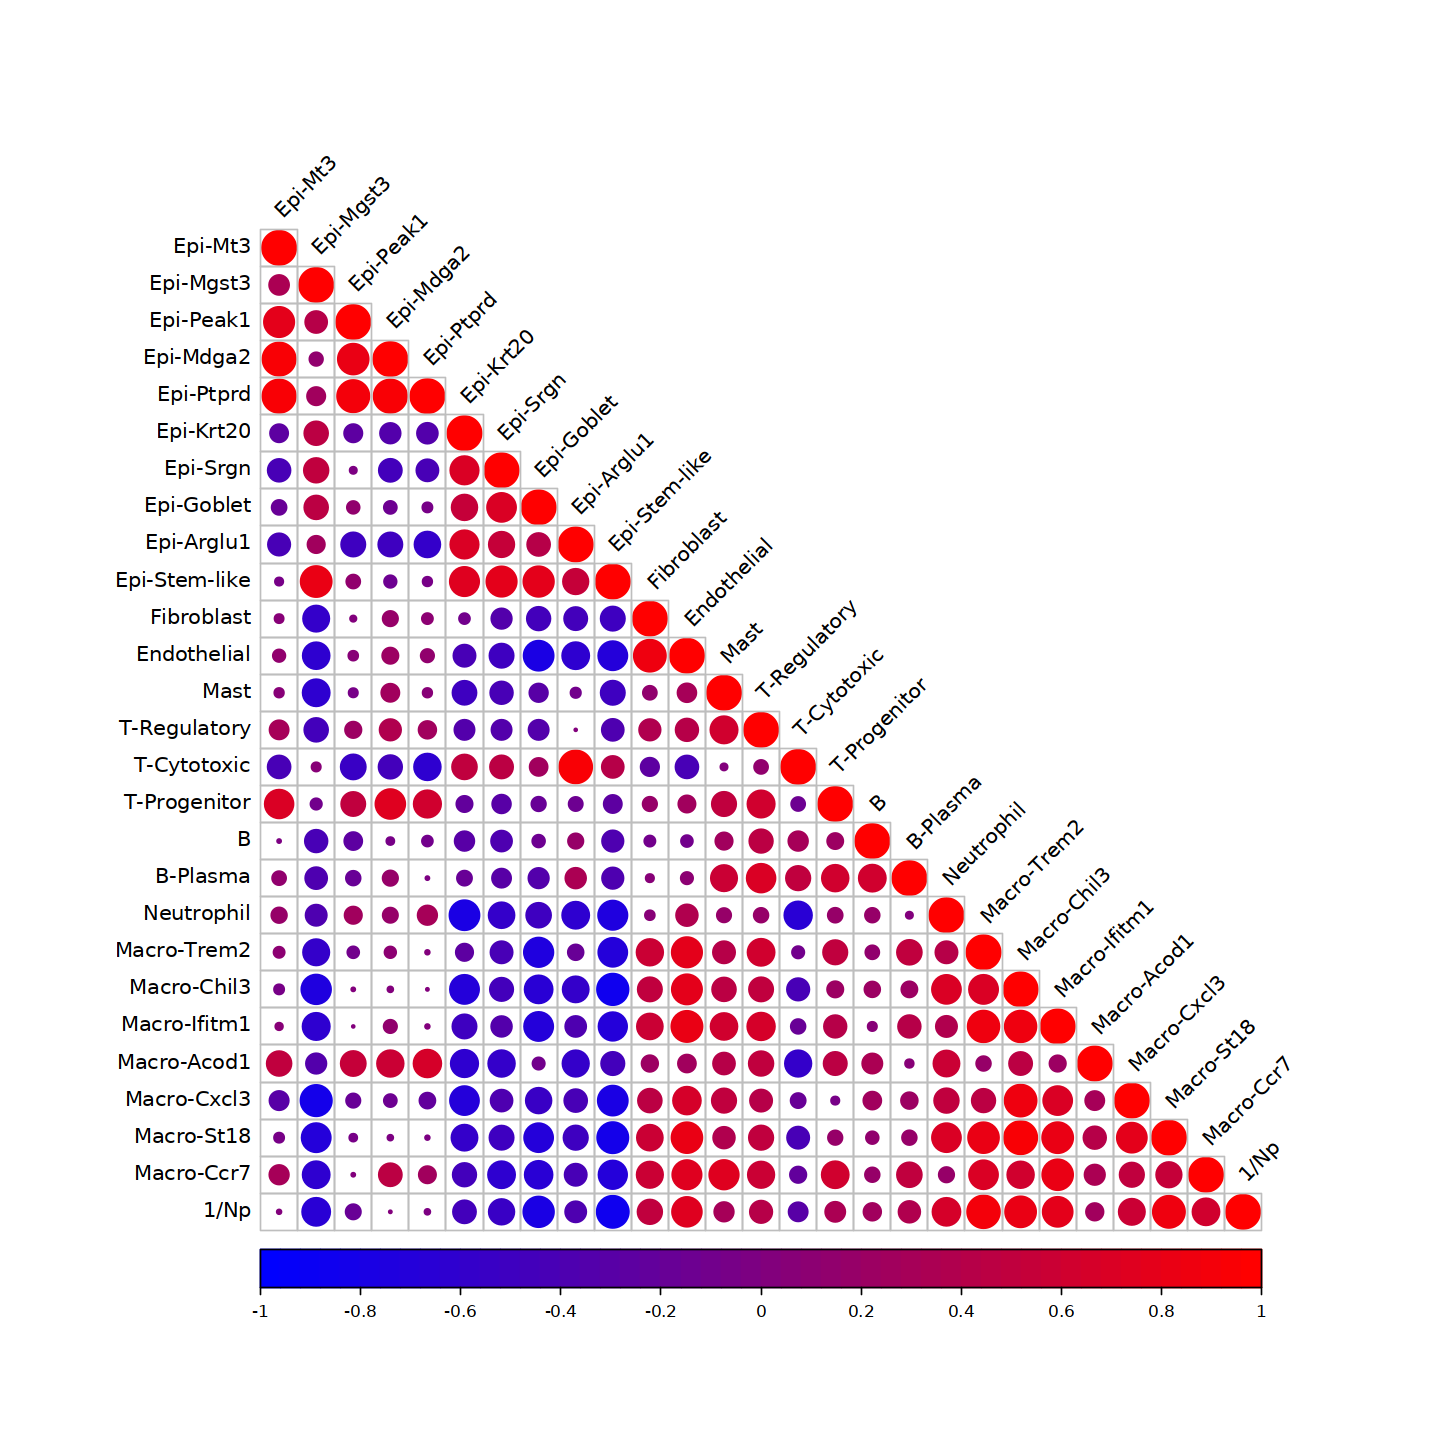

In [29]:
#pdf(file="results/plot/corplotMAIN.pdf",width = 10,height = 10)
options(repr.plot.width=12,repr.plot.height=12)
NP_cellpctCOR=corrplot(cor(matrixCombind,method = c("spearman")),
                       #p.mat = pm$p,insig='label_sig',sig.level = c(.001,.01,.05),
               #order="AOE",
               tl.srt = 45,type="lower",tl.col = 'black',pch = '*',pch.col = 'black',pch.cex = 1.5,
               diag=T,col=col)
#dev.off()

In [ ]:
pdf(file="results/plot/corNpMAIN.pdf",width = 5,height = 5)
corrMatrix=matrixCombind
plot1=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macrophage`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.65)+xlim(c(0,0.65))+ylim(c(0,0.65))

plot2=ggplot(corrMatrix,aes(x=`1/Np`,y=`Neutrophil`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.4)+xlim(c(0,0.65))+ylim(c(0,0.4))

plot3=ggplot(corrMatrix,aes(x=`1/Np`,y=`Endothelial`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.075)+xlim(c(0,0.65))+ylim(c(-0.01,0.075))

plot4=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epithelial`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 1)+xlim(c(0,0.65))+ylim(c(-0.3,1))

(plot1/plot3) | (plot2/plot4)
dev.off()

In [ ]:
pdf(file="results/plot/corNpEPI.pdf",width = 5,height = 5)
corrMatrix=matrixCombind
plot1=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epi-Mt3`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.6)+xlim(c(0,0.65))+ylim(c(0,0.6))

plot2=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epi-Mgst3`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.4)+xlim(c(0,0.65))+ylim(c(0,0.4))

plot3=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epi-Goblet`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.4)+xlim(c(0,0.65))+ylim(c(-0.3,0.4))

plot4=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epi-Stem-like`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.025)+xlim(c(0,0.65))+ylim(c(-0.015,0.025))

(plot1/plot3) | (plot2/plot4)
dev.off()

In [ ]:
pdf(file="results/plot/corNpIMM.pdf",width = 5,height = 5)
corrMatrix=matrixCombind
plot2=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Chil3`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.3)+xlim(c(0,0.65))+ylim(c(0,0.3))

plot3=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-St18`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.05)+xlim(c(0,0.65))+ylim(c(0,0.05))

plot1=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Trem2`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.4)+xlim(c(0,0.65))+ylim(c(0,0.4))

plot4=ggplot(corrMatrix,aes(x=`1/Np`,y=`T-Regulatory`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.3)+xlim(c(0,0.65))+ylim(c(0,0.3))

(plot1/plot3) | (plot2/plot4)
dev.off()

In [ ]:
pdf(file="results/plot/corNpMACRO.pdf",width = 5,height = 5)
corrMatrix=matrixCombind
plot1=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Chil3`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.5)+xlim(c(0,0.65))+ylim(c(0,0.5))

plot2=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Trem2`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.6)+xlim(c(0,0.65))+ylim(c(0,0.6))

plot3=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Acod1`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.4)+xlim(c(0,0.65))+ylim(c(-0.2,0.4))

plot4=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Cxcl3`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.5)+xlim(c(0,0.65))+ylim(c(-0.2,0.5))

(plot1/plot3) | (plot2/plot4)
dev.off()

In [ ]:
pdf(file="results/plot/corNpALL.pdf",width = 5,height = 5)
corrMatrix=matrixCombind
plot1=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Chil3`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.2)+xlim(c(0,0.65))+ylim(c(-0.05,0.2))

plot2=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Trem2`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.3)+xlim(c(0,0.65))+ylim(c(-0.05,0.3))

plot3=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-St18`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.04)+xlim(c(0,0.65))+ylim(c(-0.005,0.04))

plot4=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Ifitm1`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.1)+xlim(c(0,0.65))+ylim(c(-0.01,0.1))

(plot2/plot3) | (plot1/plot4)
dev.off()

Scale for y is already present.
Adding another scale for y, which will replace the existing scale.


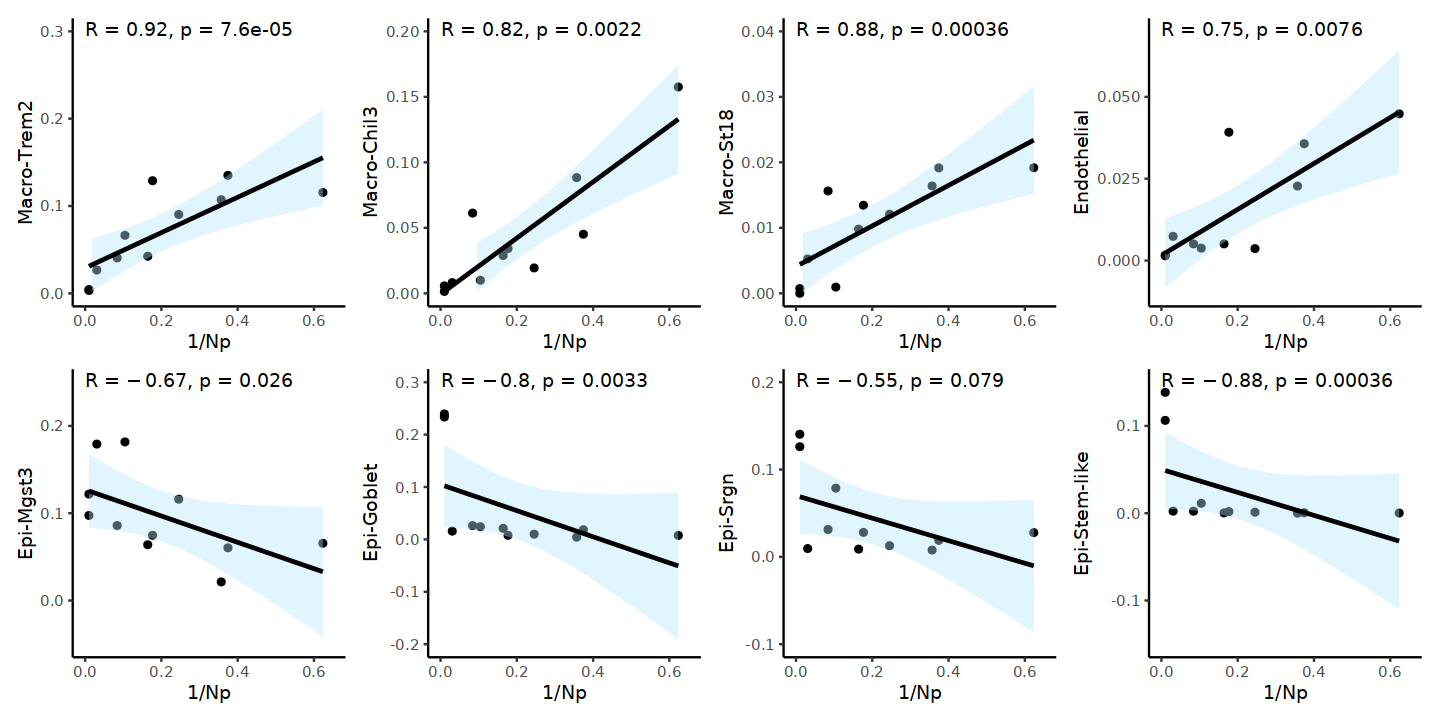

In [30]:
options(repr.plot.width=12,repr.plot.height=6)
#pdf(file="results/plot/corNpALLmore.pdf",width = 10,height = 5)
corrMatrix=matrixCombind
plot1=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Chil3`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.2)+xlim(c(0,0.65))+ylim(c(-0.05,0.2))+ylim(c(0,0.2))

plot2=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-Trem2`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.3)+xlim(c(0,0.65))+ylim(c(0,0.3))

plot3=ggplot(corrMatrix,aes(x=`1/Np`,y=`Macro-St18`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.04)+xlim(c(0,0.65))+ylim(c(0,0.04))

plot4=ggplot(corrMatrix,aes(x=`1/Np`,y=`Endothelial`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.07)+xlim(c(0,0.65))+ylim(c(-0.01,0.07))

plot5=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epi-Mgst3`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.25)+xlim(c(0,0.65))+ylim(c(-0.05,0.25))

plot6=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epi-Goblet`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.3)+xlim(c(0,0.65))+ylim(c(-0.2,0.3))

plot7=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epi-Srgn`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.2)+xlim(c(0,0.65))+ylim(c(-0.1,0.2))

plot8=ggplot(corrMatrix,aes(x=`1/Np`,y=`Epi-Stem-like`))+geom_point()+theme_classic()+
geom_smooth(method = "lm", formula = y ~ x, color = "black", fill = "#b2e7fa",alpha = 0.4)+
stat_cor(method = "spearman",label.x = 0,label.y = 0.15)+xlim(c(0,0.65))+ylim(c(-0.15,0.15))

(plot2/plot5) | (plot1/plot6) | (plot3/plot7) | (plot4/plot8)
#dev.off()

# Gsva

## matrix

In [31]:
matrixdata=scdata[["SCT"]]@data

In [32]:
matrixdata=as.matrix(matrixdata)

Warning message in asMethod(object):
“sparse->dense coercion: allocating vector of size 7.7 GiB”


## hallmarker

In [33]:
mgt=read.gmt("/data2/xiangwei/xiangwei/ref/GSEA/mouse/mh.all.v2023.1.Mm.symbols.gmt")

In [34]:
head(mgt)
dim(mgt)
length(table(mgt$term))

,term,gene
,<fct>,<chr>
1,HALLMARK_TNFA_SIGNALING_VIA_NFKB,Klf6
2,HALLMARK_TNFA_SIGNALING_VIA_NFKB,Jag1
3,HALLMARK_TNFA_SIGNALING_VIA_NFKB,Dennd5a
4,HALLMARK_TNFA_SIGNALING_VIA_NFKB,Gch1
5,HALLMARK_TNFA_SIGNALING_VIA_NFKB,B4galt1
6,HALLMARK_TNFA_SIGNALING_VIA_NFKB,Icam1


[1] 7189    2

[1] 50

In [35]:
gmtlist=vector("list",length = length(table(mgt$term)))
names(gmtlist)=names(table(mgt$term))

In [36]:
for(i in seq_along(gmtlist)){
onePathwaySet=mgt%>%filter(term==names(gmtlist)[i])
gmtlist[[i]]=onePathwaySet$gene
}

## qian marker

In [37]:
IFN_TAMs=c("Ccl2","Ccl7","Ccl8","Cd274","Cxcl9","Cxcl10","Cxcl11","Ifit1","Ifit2","Ifit3","Ifit3", 
           "Ifitm1","Ifitm3", "Il7r","Isg15", "Nos2", "Rsad2","Tnfsf10", "Stat1")

Inflam_TAMs=c("Cxcl1","Cxcl2","Cxcl3","Cxcl5","Cxcl8","Ccl20", "Ccl3l1", "Il1rn","Il1b", "G0s2",
              "Inhba","Spp1")

LA_TAMs=c("Acp5","Apoc1","Apoe","C1qa","C1qb", "C1qc","Ccl18","Ccl8","Cd163","Cd206","Cd36","Cd63",
          "Ctsb","Ctsd","Ctsl","Cxcl9","Fabp5","Folr2","Gpnmb","Lgals3","Macro","Mrc1","Trem2")

Angio_TAMs=c("Arg1","Adam8","Bnip3","Mif","Slc2a1")

Reg_TAMs=c("Apoe","Arg1","C1qa","Ccl2","Cd63","Clec4d","Cx3cr1","Gpnmb","Hilpda","Hmox1","Il7r",
           "Mrc1","Pf4","Spp1","Trem2","Vegfa","Itga4")

Prolif_TAMs=c("Cdk1","Mki67","Stmn1","Top2a","Tubb")

RTM_TAMs=c("Krt79","Krt19","Car4",
           "Bin1","Cst7","Cxcl13","Hexb","Nav3","P2ry12","Sall1","Siglech","Sparc")

In [38]:
setdiff(IFN_TAMs,rownames(matrixdata))
setdiff(Inflam_TAMs,rownames(matrixdata))
setdiff(LA_TAMs,rownames(matrixdata))
setdiff(Angio_TAMs,rownames(matrixdata))
setdiff(Reg_TAMs,rownames(matrixdata))
setdiff(Prolif_TAMs,rownames(matrixdata))
setdiff(RTM_TAMs,rownames(matrixdata))

[1] "Cxcl11"

[1] "Cxcl8"  "Ccl3l1"

[1] "Ccl18" "Cd206" "Macro"

character(0)

character(0)

[1] "Tubb"

character(0)

In [39]:
qianGeneSet=list(IFN_TAMs=IFN_TAMs,Inflam_TAMs=Inflam_TAMs,
                   LA_TAMs=LA_TAMs,Angio_TAMs=Angio_TAMs,
                   Reg_TAMs=Reg_TAMs,Prolif_TAMs=Prolif_TAMs,
                   RTM_TAMs=RTM_TAMs)

## merge pathwags

In [40]:
mergeList=c(qianGeneSet,gmtlist)

## gsva analysis

In [41]:
gsva_res=gsva(matrixdata,mergeList,parallel.sz=10,method="ssgsea")

Warning message in .filterFeatures(expr, method):
“1543 genes with constant expression values throuhgout the samples.”


Setting parallel calculations through a MulticoreParam back-end
with workers=10 and tasks=100.
Estimating ssGSEA scores for 57 gene sets.
[1] "Calculating ranks..."
[1] "Calculating absolute values from ranks..."
  |======================================================================| 100%

[1] "Normalizing..."


In [42]:
gsvaRES=as.data.frame(gsva_res)
gsvaRES[1:3,1:3]
dim(gsvaRES)

,WT_1.bcHTXJ,WT_1.bcHGRE,WT_1.bcHIFA
,<dbl>,<dbl>,<dbl>
IFN_TAMs,0.1392242,0.09244035,0.2540444
Inflam_TAMs,0.1212209,0.11826697,0.1305896
LA_TAMs,0.4110824,0.42724845,0.4102957


[1]    57 45620

In [43]:
write.table(gsvaRES,"results/gsvaRES.csv",sep = ",")

In [2]:
gsvaRES=read.table("results/gsvaRES.csv",sep = ",")

## heatmap

In [45]:
heatmapData=t(gsvaRES) %>% as.data.frame() %>% rownames_to_column(var="cellID")%>% 
            mutate(cluster=metadata$fine) %>% relocate(cluster,.before = cellID)

In [46]:
# sum cluster
clusterSUM=heatmapData %>% group_by(cluster) %>% summarise(across(contains("_"),mean)) %>% t() %>% as.data.frame()

In [47]:
colname=clusterSUM[1,] %>% as.character()

In [48]:
rowname=rownames(clusterSUM[-1,])
length(rowname)

[1] 57

In [49]:
clusterSUM=clusterSUM[-1,]
clusterSUM=as.data.frame(lapply(clusterSUM,as.numeric))
colnames(clusterSUM)=colname
rownames(clusterSUM)=rownames(gsvaRES)
clusterSUM[1:5,1:5]
dim(clusterSUM)

,Epi-Mt3,Epi-Mgst3,Epi-Peak1,Epi-Mdga2,Epi-Ptprd
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
IFN_TAMs,0.1654937,0.1275819,0.1517153,0.12272590,0.1128984
Inflam_TAMs,0.1349705,0.1673232,0.1968242,0.10084060,0.1472493
LA_TAMs,0.3691652,0.3739766,0.3843007,0.31393830,0.3269965
Angio_TAMs,0.4481824,0.4614283,0.4307458,0.34528180,0.3704356
Reg_TAMs,0.1054072,0.1174574,0.1463306,0.07982696,0.1011705


[1] 57 26

In [50]:
write.table(clusterSUM,"results/clusterSUM.csv",sep = ",")

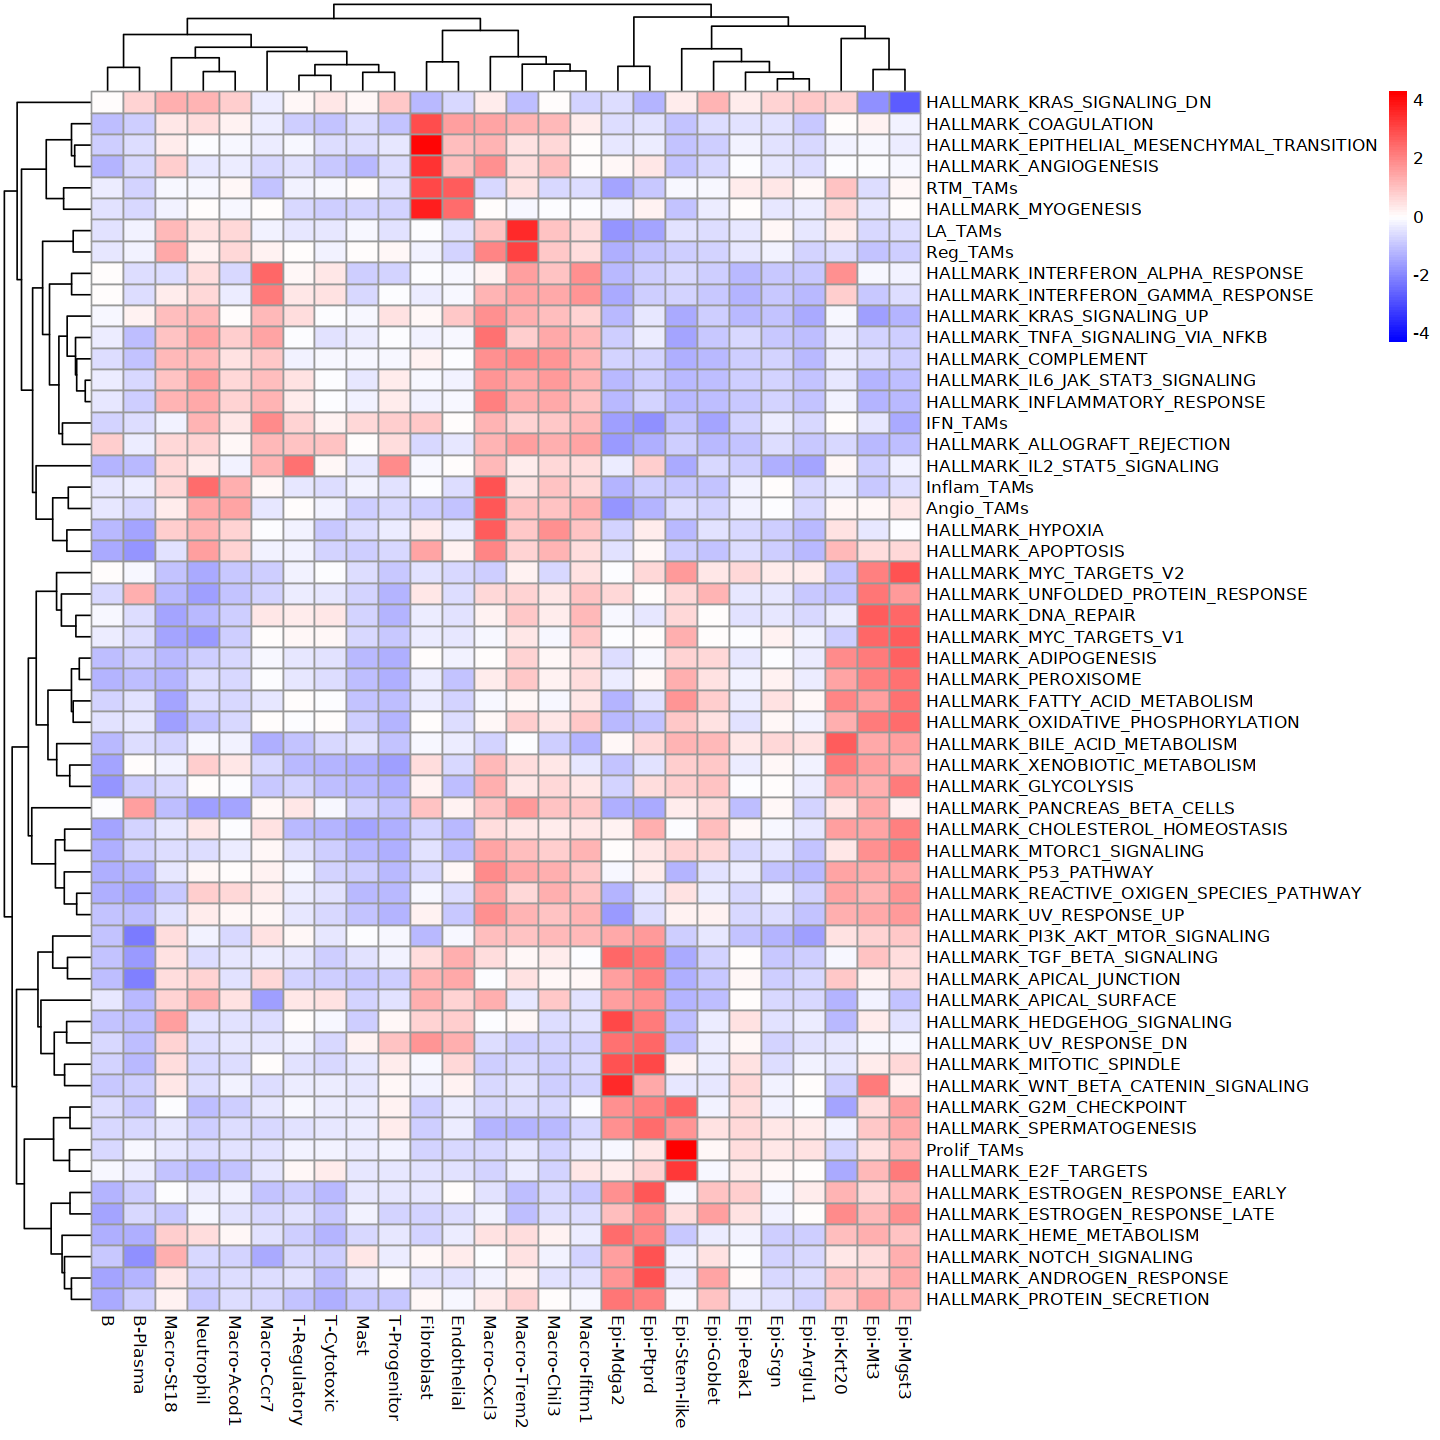

In [51]:
options(repr.plot.width=12,repr.plot.height=12)
gsvaheatmap=pheatmap::pheatmap(as.matrix(clusterSUM), #热图的数据
                   cluster_rows =T,#行聚类
                   cluster_cols =T,#列聚类，可以看出样本之间的区分度
                   #annotation_col = treatmentGroup,
                   show_colnames=T,
                   scale = "row", #以行来标准化，这个功能很不错
                   color =colorRampPalette(c("blue", "white","red"))(100))

In [52]:
ggsave(gsvaheatmap,filename = "results/plot/gsvaheatmapnew.pdf",width = 10,height = 10)

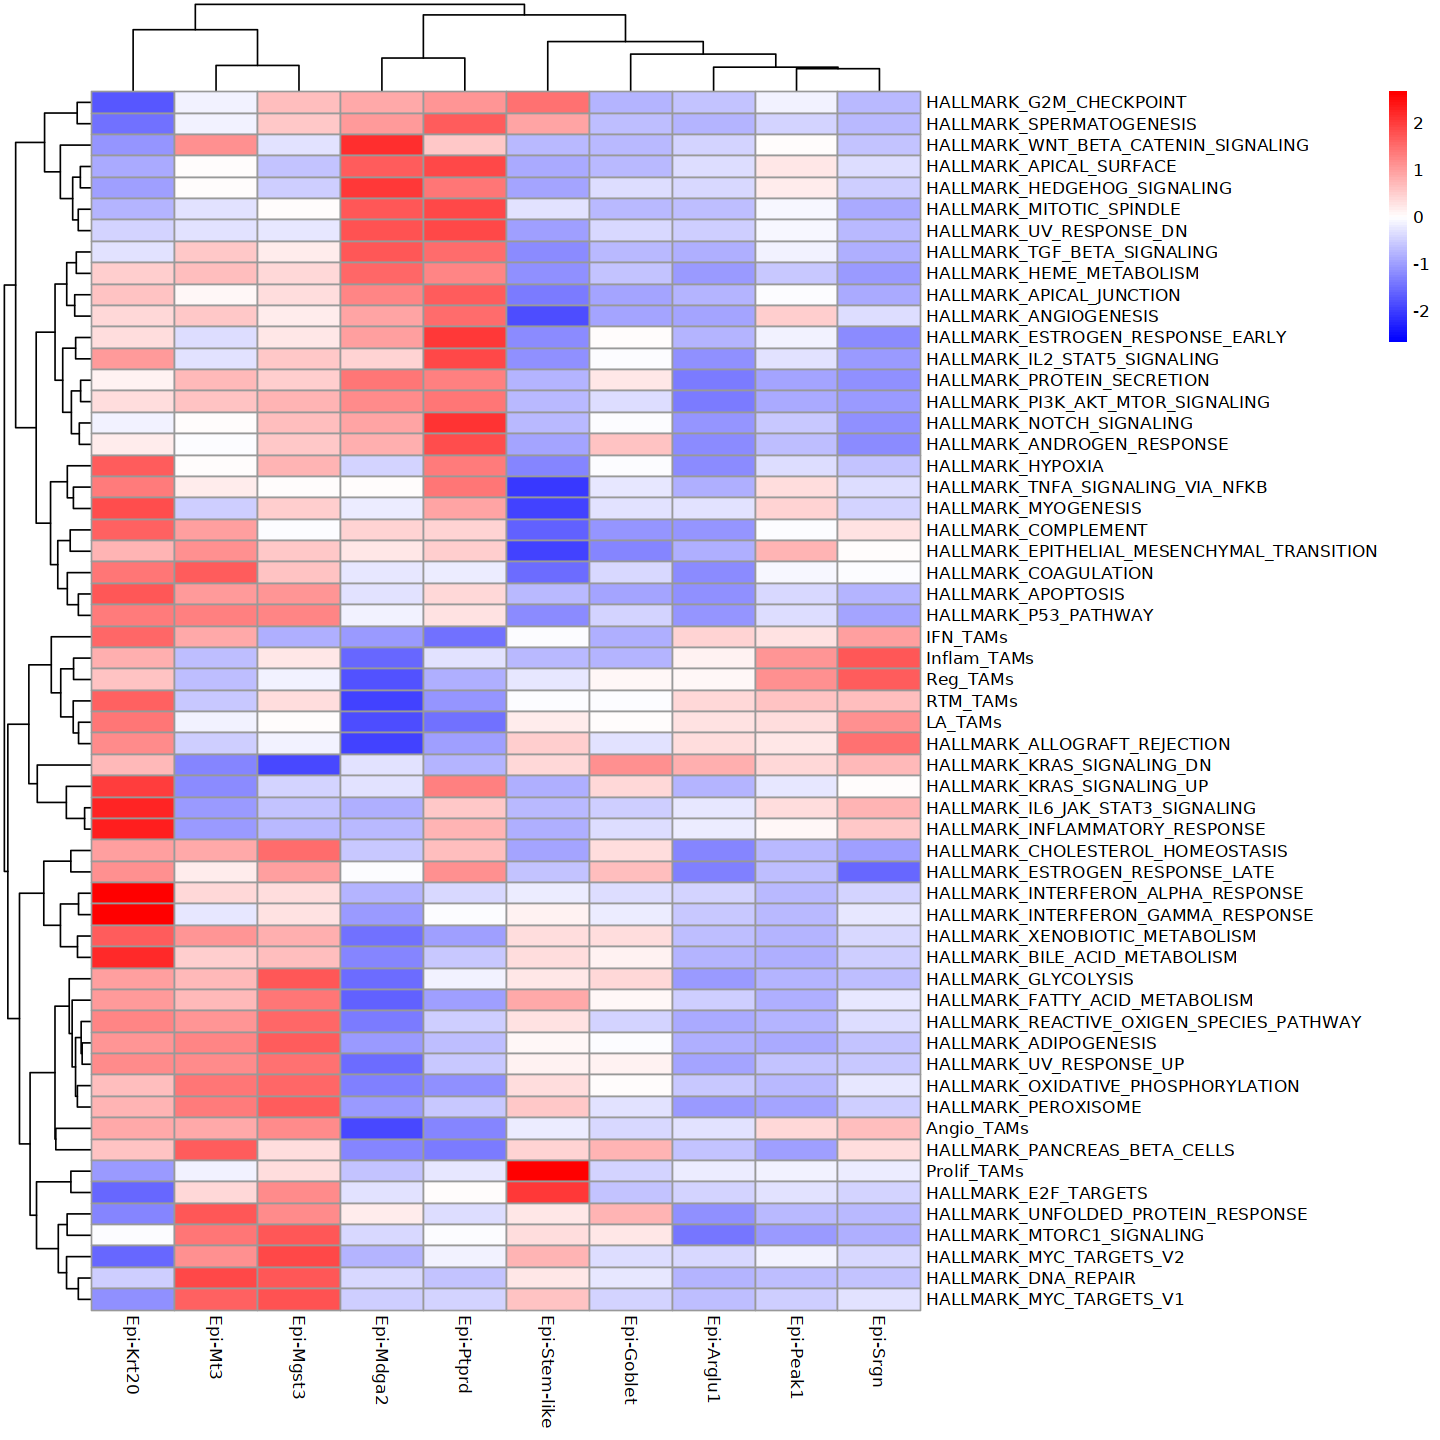

In [54]:
gsvaheatmap=pheatmap::pheatmap(as.matrix(clusterSUM[,1:10]), #热图的数据
                   cluster_rows =T,#行聚类
                   cluster_cols =T,#列聚类，可以看出样本之间的区分度
                   #annotation_col = treatmentGroup,
                   show_colnames=T,
                   scale = "row", #以行来标准化，这个功能很不错
                   color =colorRampPalette(c("blue", "white","red"))(100))

In [55]:
ggsave(gsvaheatmap,filename = "results/plot/gsvaheatmapEpi.pdf",width = 10,height = 10)

# GSVA UMPA

In [59]:
macroScdata=subset(scdata,main %in% c("Macrophage"))

Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”


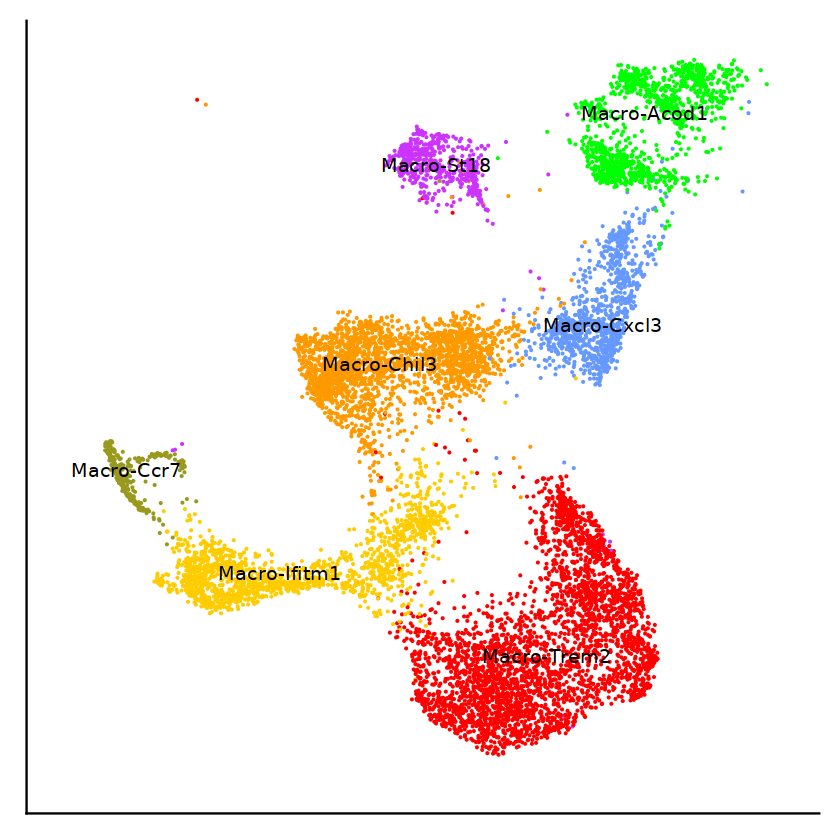

In [60]:
options(repr.plot.width=7,repr.plot.height=7)
macroPlot=DimPlot(macroScdata,reduction = "umap.harmony",
  group.by = c( "fine"), label = T,order=F,pt.size=0.1,cols=fineColor,alpha=1)+
labs(x = NULL, y = NULL)+
theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), 
      axis.text.x = element_blank(), axis.ticks.x = element_blank())+
theme(plot.title = element_blank())+
NoLegend()+
xlim(c(-7.5,5))+ylim(-15,-3)
macroPlot

Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Scale for y is already present.
Adding another scale for y, which will replace the existing scale.
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”


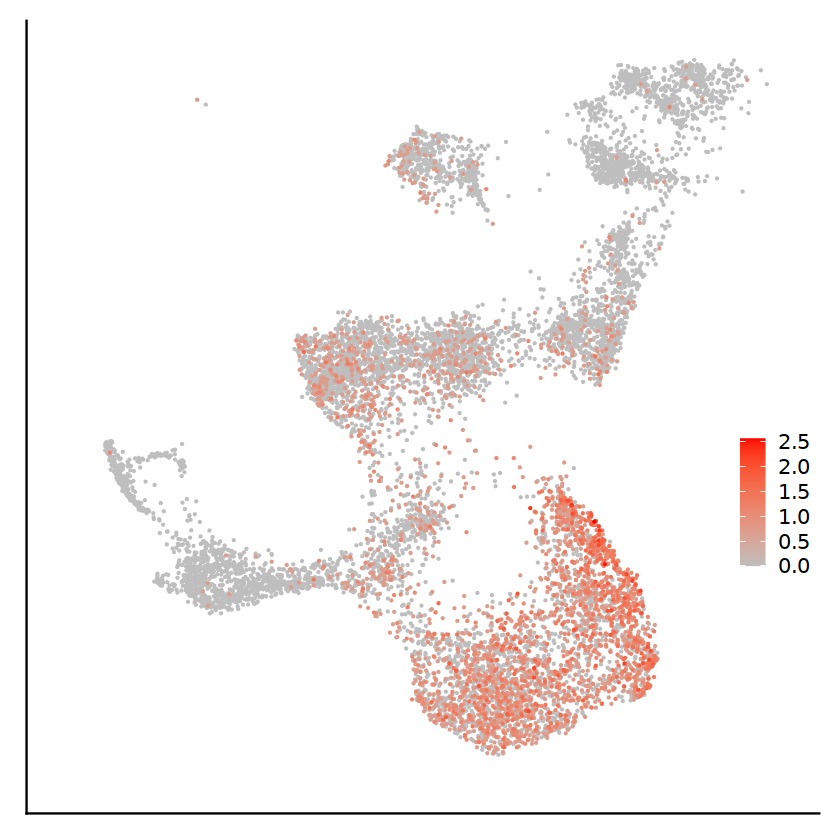

In [61]:
options(repr.plot.width=7,repr.plot.height=7)
Trem2Plot=FeaturePlot(macroScdata, features = c("Trem2"),
            reduction = "umap.harmony",cols=c("grey","red"),
            order = T)+
labs(x = NULL, y = NULL)+
theme(axis.text.y = element_blank(), axis.ticks.y = element_blank(), 
      axis.text.x = element_blank(), axis.ticks.x = element_blank())+
theme(plot.title = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+
  theme(legend.position = c(0.9, 0.4),
        legend.background = element_rect(fill = "transparent")
       )

Trem2Plot

In [62]:
umapdata=scdata@reductions$umap.harmony@cell.embeddings

In [ ]:
head(umapdata)

In [64]:
GsvaRes=t(gsvaRES)
head(GsvaRes)
cellID=rownames(GsvaRes)

,IFN_TAMs,Inflam_TAMs,LA_TAMs,Angio_TAMs,Reg_TAMs,Prolif_TAMs,RTM_TAMs,HALLMARK_TNFA_SIGNALING_VIA_NFKB,HALLMARK_HYPOXIA,HALLMARK_CHOLESTEROL_HOMEOSTASIS,⋯,HALLMARK_HEME_METABOLISM,HALLMARK_COAGULATION,HALLMARK_IL2_STAT5_SIGNALING,HALLMARK_BILE_ACID_METABOLISM,HALLMARK_PEROXISOME,HALLMARK_ALLOGRAFT_REJECTION,HALLMARK_SPERMATOGENESIS,HALLMARK_KRAS_SIGNALING_UP,HALLMARK_KRAS_SIGNALING_DN,HALLMARK_PANCREAS_BETA_CELLS
WT_1.bcHTXJ,0.13937049,0.1203810,0.4179701,0.5403875,0.1343763,-0.07141943,0.1423810,0.12816478,0.1348562,0.2077914,⋯,0.1591069,0.13695559,0.1393020,0.1833385,0.2226023,0.1287182,-0.0170198009,0.12262130,0.027282563,0.05644202
WT_1.bcHGRE,0.09501172,0.1215568,0.4391331,0.4839836,0.1140047,0.62084073,0.1069009,0.09125051,0.1315243,0.1955614,⋯,0.1617745,0.09764609,0.1411664,0.1474155,0.3025959,0.1846832,-0.0022127992,0.09449234,-0.012754582,0.04121119
WT_1.bcHIFA,0.26111109,0.1342222,0.4217087,0.6965100,0.1247542,-0.06189684,0.1521741,0.14861682,0.1717180,0.2270820,⋯,0.1898332,0.10053631,0.1666312,0.1859159,0.2400293,0.1640718,0.0060949399,0.14643547,0.002863783,0.04364430
WT_1.bcHFJN,0.22441955,0.2093813,0.4065989,0.3132698,0.1216614,-0.06420309,0.1193956,0.14721021,0.1710800,0.2915133,⋯,0.1630003,0.12617781,0.1600303,0.1404590,0.3064756,0.1935174,0.0002721253,0.12306668,0.009941218,0.09110801
WT_1.bcGOTP,0.13588729,0.2173732,0.4323452,0.5265428,0.1088662,0.54142732,0.1028563,0.13258337,0.1242176,0.1959878,⋯,0.1664304,0.08527199,0.1237002,0.1827156,0.3102534,0.1774941,0.0327464243,0.09881075,-0.023760343,0.14987381
WT_1.bcFBTL,0.10518948,0.2113124,0.4398847,0.6928985,0.1230196,-0.06284538,0.1207341,0.15761774,0.1966453,0.3002007,⋯,0.1606328,0.11537766,0.1951604,0.2111443,0.3102334,0.1710882,-0.0101462074,0.13829781,0.002498228,0.02435028


In [65]:
df=data.frame(umapdata,GsvaRes)

In [66]:
df=df[rownames(df) %in% rownames(macrodata),]

Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”


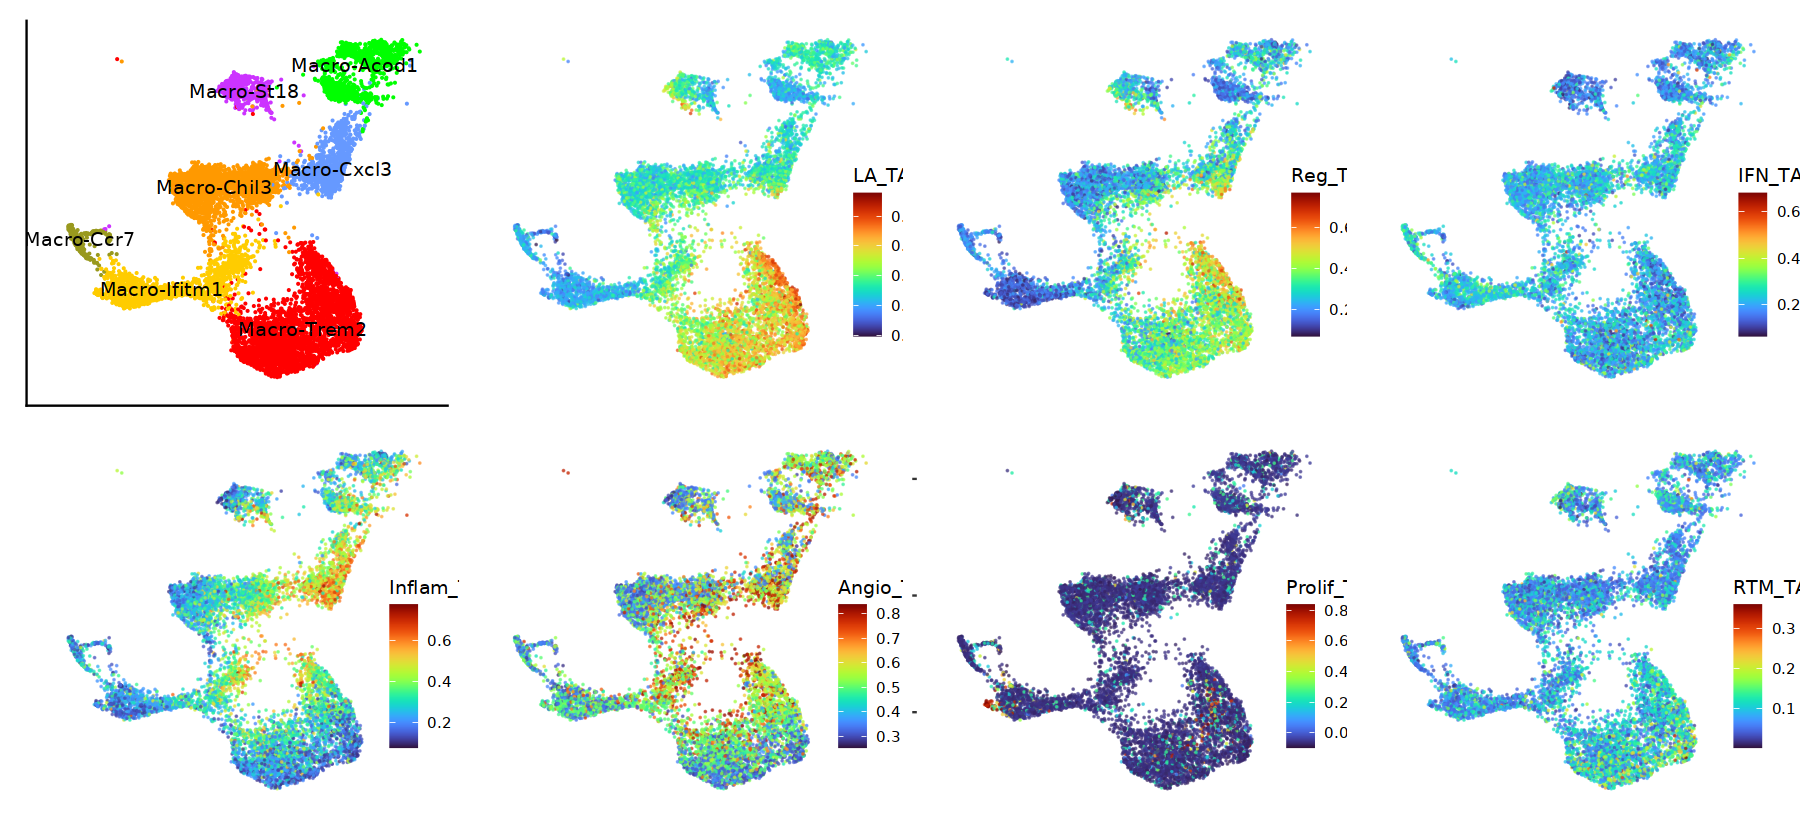

In [73]:
options(repr.plot.width=15,repr.plot.height=7)
#pdf("results/plot/macroQiangGsvaALL.pdf",width = 12,height = 6)
IFN_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=IFN_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )


Inflam_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=Inflam_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )


LA_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=LA_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )


Angio_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=Angio_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )


Reg_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=Reg_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )


Prolif_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=Prolif_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),)+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )


RTM_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=RTM_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )


macroPlot+LA_TAMs+Reg_TAMs+IFN_TAMs+Inflam_TAMs+Angio_TAMs+Prolif_TAMs+RTM_TAMs+plot_layout(ncol = 4, byrow = T)
        
#dev.off()

Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”
Warning message:
“Removed 26 rows containing missing values (`geom_point()`).”


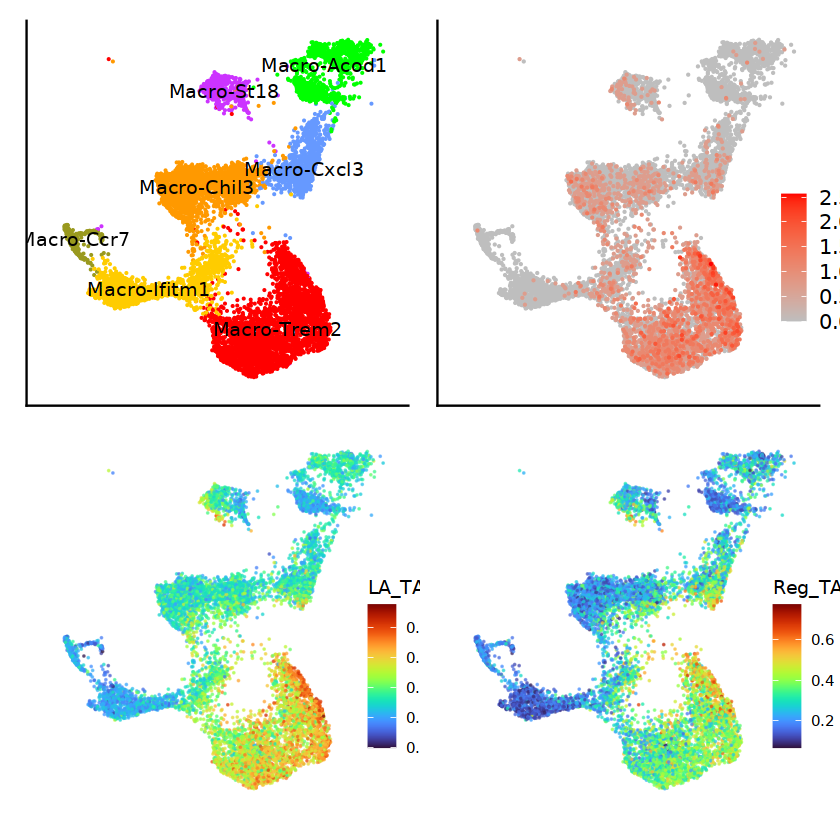

In [74]:
#pdf("results/plot/macroQiangGsva4.pdf",width = 8,height = 8)
options(repr.plot.width=7,repr.plot.height=7)
LA_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=LA_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )



Reg_TAMs=ggplot(df,aes(umapharmony_1,umapharmony_2))+geom_point(aes(color=Reg_TAMs),size=0.01,alpha=0.6)+
viridis::scale_color_viridis(option = "H",alpha = 1)+theme(panel.background = element_blank())+
xlim(c(-7.5,5))+ylim(-15,-3)+labs(x = NULL, y = NULL)+
  theme(axis.text.x = element_blank(),
        axis.ticks.x = element_blank(),
        axis.text.y = element_blank(),
        axis.ticks.y = element_blank())+
  theme(legend.position = c(1, 0.4),
        legend.background = element_rect(fill = "transparent")
       )


macroPlot+Trem2Plot+LA_TAMs+Reg_TAMs+plot_layout(ncol = 2, byrow = T)
        
#dev.off()